# Modelling 

The goal is to obtain the traffic model that gives the covariance kernel its shape.

The first model is: $x_k = x_0 + k v_0 + \frac{2n-1}{2} \epsilon$. This corresponds to the model where $x_{k+1} = x_k + v_{k+1}$ and $v_{k+1} = v_k + \epsilon$ where $\epsilon \sim \mathcal{N}(0,\sigma_\epsilon^2)$ i.e., i.i.d. acceleration model.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt 

from scipy.stats import norm

%matplotlib inline 

In [3]:
def step(xk, vk):
    ak_plus_1 = norm.rvs(loc = 0, scale = 0.02)
    vk_plus_1 = vk + ak_plus_1
    xk_plus_1 = xk + vk_plus_1
    return (xk_plus_1, vk_plus_1)

In [4]:
num_of_trajs = 200
length_of_trajs = 270
trajs = np.zeros((num_of_trajs, length_of_trajs))
trajs_v = np.zeros((num_of_trajs, length_of_trajs))
for i in range(num_of_trajs):
    xk = 0
    vk = 0
    for j in range(length_of_trajs):
        new_xk, new_vk = step(xk, vk)
        trajs[i,j] = new_xk
        trajs_v[i,j] = new_vk
        xk = new_xk
        vk = new_vk

The trajectory should be integral of a Wiener process:

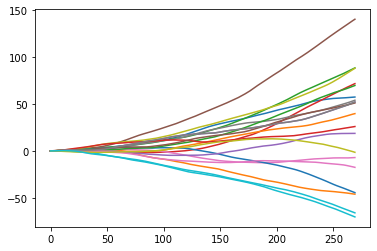

In [5]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(trajs[i,:])

The velocity, since being integration of normal i.i.d. random variable, should be a Wiener process:

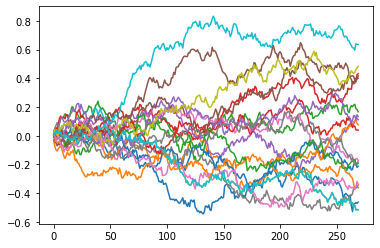

In [6]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(trajs_v[i,:])

Let's find the covariance matrix (of the trajectories):

In [7]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
fdgr = skfda.FDataGrid(trajs, np.arange(trajs.shape[1]))
fdgrv = skfda.FDataGrid(trajs_v, np.arange(trajs_v.shape[1]))

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


FPCA of velocity profiles:

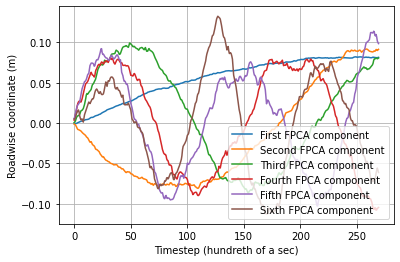

In [8]:
fpca_v = FPCA(n_components=6)
fpca_v.fit(fdgrv)
fpca_v.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

FPCA of position profiles:

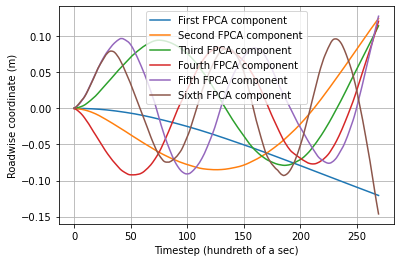

In [9]:
fpca_x = FPCA(n_components=6)
fpca_x.fit(fdgr)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

In [10]:
fpca_scores_x = fpca_x.transform(fdgr)
fpca_scores_v = fpca_v.transform(fdgrv)

Let's take one vehicle profile and position profile as example:

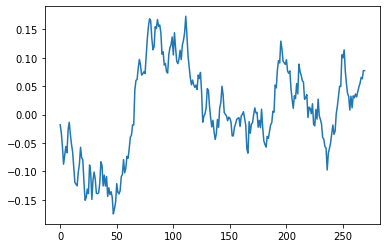

In [11]:
plt.plot(trajs_v[0])

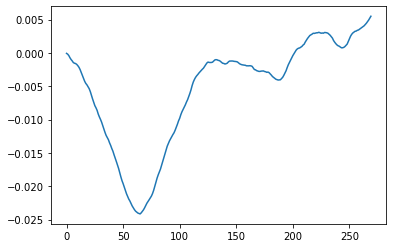

In [12]:
plt.plot(trajs[0]/270)

Analytical vs Numerical basis of the Velocity Profile:

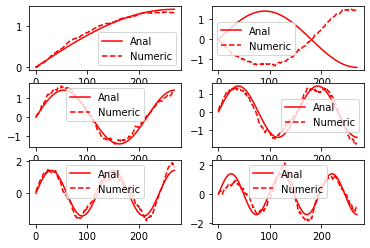

In [13]:
v_basis = np.zeros((7,270))
vr = np.arange(270)
for m in range(7):
    v_basis[m,:] = np.sqrt(2) * (np.sin(vr/270 * (m+1/2) * np.pi ))
orig_v_basis = fpca_v.components_.data_matrix.reshape((6,270)) * np.sqrt(270) # scale up the original basis due to FPCA has sampling time = 1
# i.e., 0<t<270 rather than 0<t<1. This causes the energy to be divided by sqrt(270) as integral of square must be equal to 1
for m in range(6):
    plt.subplot(3,2,m+1)
    plt.plot(vr, v_basis[m,:], 'r-', label='Anal')
    plt.plot(vr, orig_v_basis[m, :270], 'r--', label='Numeric')
    plt.legend()

Analytical vs Numerical basis of the Position profile

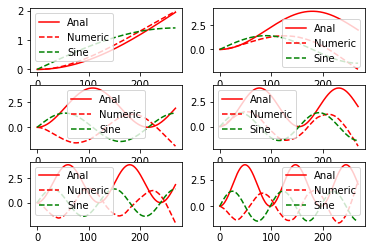

In [22]:
x_basis = np.zeros((7,270))
x_basis_not_scaled = np.zeros((7,270))
sin_basis = np.zeros((7,270))
xr = np.arange(270)
for m in range(7):
    x_basis[m,:] = -np.sqrt(2) / ((m+1/2) * np.pi) * (np.cos(xr/270 * (m+1/2) * np.pi) - 1)
    x_basis_not_scaled[m,:] = - (np.cos(xr/270 * (m+1/2) * np.pi) - 1) * 2.77 / np.sqrt(2)
    sin_basis[m,:] = np.sqrt(2) * (np.sin(xr/270 * (m+1/2) * np.pi ))
orig_x_basis = fpca_x.components_.data_matrix.reshape((6,270)) * np.sqrt(270) # scale up the original basis due to FPCA has sampling time = 1
# i.e., 0<t<270 rather than 0<t<1. This causes the energy to be divided by sqrt(270) as integral of square must be equal to 1
for m in range(6):
    plt.subplot(3,2,m+1)
    plt.plot(xr, x_basis_not_scaled[m,:], 'r-', label='Anal')
    plt.plot(xr, -orig_x_basis[m, :270], 'r--', label='Numeric')
    plt.plot(xr, sin_basis[m, :270], 'g--', label='Sine')
    plt.legend()

Reconstruct the position profile:

PCA 0: 11.57
PCA 1: 23.91
PCA 2: -25.66
PCA 3: 20.95
PCA 4: -9.16
PCA 5: 4.51


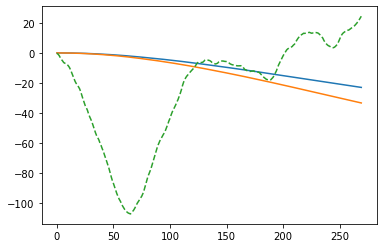

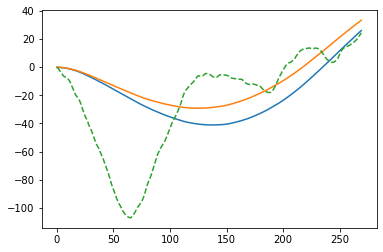

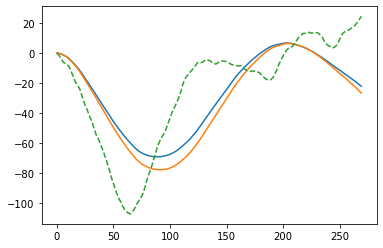

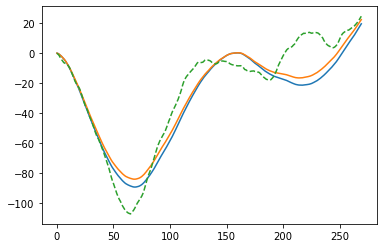

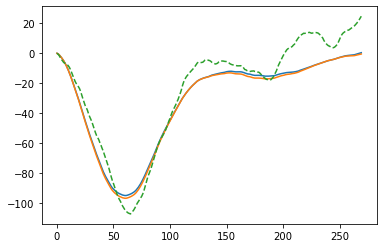

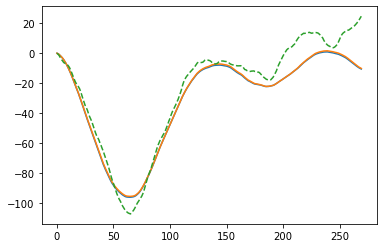

In [15]:
x0_approx = np.zeros_like(trajs[0])
x1_approx = np.zeros_like(trajs[0])
for i in range(fpca_scores_x.shape[1]):
    x0_approx = x0_approx + fpca_scores_x[0,i] * orig_x_basis[i,:] # use numerical basis
    print('PCA {:d}: {:.2f}'.format(i, fpca_scores_x[0,i]))
    if i in [0]:
        x1_approx = x0_approx - fpca_scores_x[0,i] * x_basis[i,:] # use cos(pi/2) - 1 basis family
    else:
        x1_approx = x0_approx + fpca_scores_x[0,i] * x_basis[i,:] # use cos(pi/2) - 1 basis family
    # plt.subplot(fpca_scores_x.shape[1],1,i+1)
    plt.figure()
    plt.plot(x0_approx)
    plt.plot(x1_approx)
    plt.plot(trajs[0]*np.sqrt(270), '--')

Seems like cos((k-1/2)pi) - 1 do indeed form a basis, albeit not orthonormal nor orthogonal.

In [16]:
cov_mtrx = 
plt.imshow(cov_mtrx)
plt.axis('equal')

SyntaxError: invalid syntax (68097049.py, line 1)

(0.0, 269.0, 0.0, 269.0)

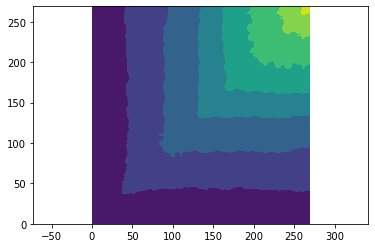

In [ ]:
fdgrv = skfda.FDataGrid(trajs_v, np.arange(trajs_v.shape[1]))
cov_mtrxv = fdgrv.cov().data_matrix[0,:270,:270,0]
plt.contourf(cov_mtrxv)
plt.axis('equal')

# Creating the covariance matrix from analytical formula

(0.0, 999.0, 0.0, 999.0)

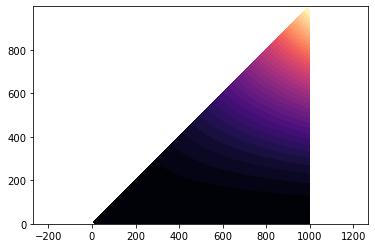

In [ ]:
N = 1000
cov_anal = np.zeros((N,N))

for k in range(N):
    for j in range(k,N):
        cov_anal[k,j] = 1/2 * k * (k+1) * (np.abs(j-k) + 1/3 * (2*k+1))
        # cov_anal[k,j] = 1/2 * k * (k+1) * (np.abs(j-k))
# now cov_anal is upper-triangle
# cov_anal = cov_anal + cov_anal.T - np.diag(cov_anal.diagonal())
plt.contourf(cov_anal, cmap='magma', levels=np.arange(100, np.max(cov_anal), np.max(cov_anal)/40))
plt.axis('equal')

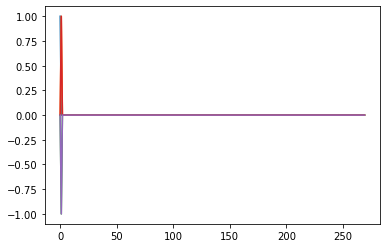

In [ ]:
l,v = np.linalg.eig(cov_anal)
for i in range(5):
    plt.plot(v[:,i])

So we have obtained again, the "same" basis. Finding the eigenvectors numerically could be straightforward, but analytical results seem far fetched. The question is now can we approximate this thing via:

a) A manageable matrix after approximated, or

b) Asymptotic convergence.

In [ ]:
T = np.zeros_like(cov_anal)
for row in range(N):
    for j in range(row, N):
        T[row,j] = j-row
# now T is upper-triangle
# T = T + T.T - np.diag(T) # make the matrix symmetric

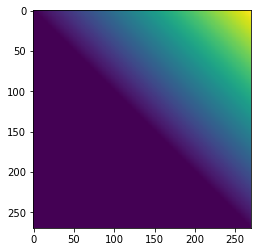

In [ ]:
plt.imshow(T, interpolation='nearest')

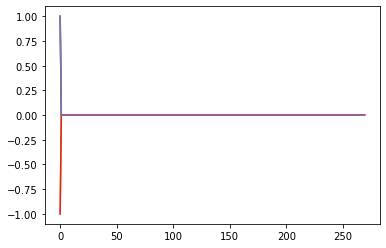

In [ ]:
lt,vt = np.linalg.eig(T)
for i in range(5):
    plt.plot(vt[:,i])

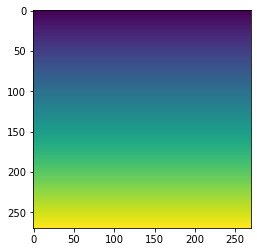

In [ ]:
W = np.zeros_like(cov_anal)
for row in range(N):
    for j in range(N):
        W[row,j] = 2 * (row + 1) + 1 
plt.imshow(W, interpolation='nearest')

 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part
 /Users/thinhhoang/miniforge3/envs/liberty/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning:Casting complex values to real discards the imaginary part


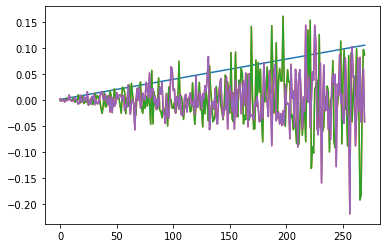

In [ ]:
lw,vw = np.linalg.eig(W)
for i in range(5):
    plt.plot(vw[:,i])

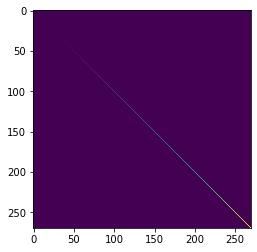

In [ ]:
G = np.zeros((N,))
for i in range(1,N+1):
    G[i-1] = i * (i+1)
G = np.diag(G)
plt.imshow(G, interpolation='nearest')

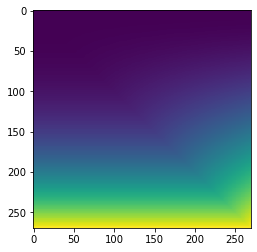

In [ ]:
plt.imshow(G @ (T + W/3), interpolation='nearest')